In [1]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_asset = pd.read_csv('Portfolio_Betas.csv')

In [3]:
df_residuals = pd.read_csv('Portfolio_Residuals.csv')
df_residuals = pd.read_csv('Portfolio_Residuals.csv')
df_residuals = df_residuals.set_index('Unnamed: 0')

In [4]:
corr_residuals = df_residuals.corr()
cov_residuals = np.array(df_residuals.cov())
alphas = np.array(df_asset['Intercept'])

In [5]:
initial_weight = np.array(df_asset['Beta_weight'])

In [6]:
df_asset.columns

Index(['Unnamed: 0', 'Symbol', 'Description', 'Quantity', 'Currency',
       'LastPrice', 'PricePaid', 'DayChange', 'ProfitLoss', 'MarketValue',
       'ProfitLossPercentage', 'Long(1)/Short(-1)', 'Position_Weight',
       'Intercept', 'mkt', 'smb', 'hml', 'rmw', 'cma', 'Ticker',
       'Market_Position', 'Beta_weight'],
      dtype='object')

In [7]:
betas = df_asset.loc[:,['mkt', 'smb', 'hml', 'rmw', 'cma']]

In [8]:
def beta_calculation_long_short_strategy(beta_i_s, weight_i):
    # beta_i_s : np array
    # weight_i : np array
    return (beta_i_s@weight_i)*2

#beta_calculation_long_short_strategy(np.array(df_asset['mkt']), initial_weight)

In [9]:
def portfolio_variance(weight, covariance_matrix):
    # multiply how much for a leveraged strategy? 
    return np.dot(weight.T, np.dot(covariance_matrix, weight)) * 4
# portfolio_variance(initial_weight, cov_residuals)

In [10]:
def portfolio_alpha(weight, alphas):
    # multiply how much for a leveraged strategy? 2
    return (weight@alphas)*2
# portfolio_alpha(initial_weight, alphas)

# Beta Constraint

In [11]:
mkt_beta_upper_bound = 0.05
mkt_beta_lower_bound = -0.05

smb_beta_upper_bound = - 0.95
smb_beta_lower_bound = - 1.05 #-100

hml_beta_upper_bound = 0.05
hml_beta_lower_bound = -0.05

rmw_beta_upper_bound = 0.05
rmw_beta_lower_bound = -0.05

cma_beta_upper_bound = 0.05
cma_beta_lower_bound = -0.05

'''
Scenario 1

mkt_beta_upper_bound = 1
mkt_beta_lower_bound = 0.25

smb_beta_upper_bound = - 1
smb_beta_lower_bound = - 2 #-100

hml_beta_upper_bound = 0.05
hml_beta_lower_bound = -0.05

rmw_beta_upper_bound = 0.05
rmw_beta_lower_bound = -0.05

cma_beta_upper_bound = 0.05
cma_beta_lower_bound = -0.05
'''



def Constraint_mkt_beta_lower_bound(weight):
    global betas
    return beta_calculation_long_short_strategy(np.array(betas['mkt']), weight) - (mkt_beta_lower_bound )
def Constraint_smb_beta_lower_bound(weight):
    global betas
    return beta_calculation_long_short_strategy(np.array(betas['smb']), weight) - (smb_beta_lower_bound )
def Constraint_hml_beta_lower_bound(weight):
    global betas
    return beta_calculation_long_short_strategy(np.array(betas['hml']), weight) - (hml_beta_lower_bound )
def Constraint_rmw_beta_lower_bound(weight):
    global betas
    return beta_calculation_long_short_strategy(np.array(betas['rmw']), weight) - (rmw_beta_lower_bound )
def Constraint_cma_beta_lower_bound(weight):
    global betas
    return beta_calculation_long_short_strategy(np.array(betas['cma']), weight) - (cma_beta_lower_bound )


def Constraint_mkt_beta_upper_bound(weight):
    global betas
    return (mkt_beta_upper_bound) - beta_calculation_long_short_strategy(np.array(betas['mkt']), weight) 
def Constraint_smb_beta_upper_bound(weight):
    global betas
    return (smb_beta_upper_bound ) - beta_calculation_long_short_strategy(np.array(betas['smb']), weight) 
def Constraint_hml_beta_upper_bound(weight):
    global betas
    return (hml_beta_upper_bound) - beta_calculation_long_short_strategy(np.array(betas['hml']), weight) 
def Constraint_rmw_beta_upper_bound(weight):
    global betas
    return (rmw_beta_upper_bound) - beta_calculation_long_short_strategy(np.array(betas['rmw']), weight) 
def Constraint_cma_beta_upper_bound(weight):
    global betas
    return (cma_beta_upper_bound ) - beta_calculation_long_short_strategy(np.array(betas['cma']), weight) 

# ['mkt', 'smb', 'hml', 'rmw', 'cma']

# Weight Constraint

In [12]:
weight_sum_upper_bound = 0.05
weight_sum_lower_bound = -0.05


long_short_ratio_upper_bound = 1.05
long_short_ratio_lower_bound = 0.95

def Constraint_weight_sum_lower_bound(weight):
    return np.sum(weight) - (weight_sum_lower_bound)

def Constraint_weight_sum_upper_bound(weight):
    return  (weight_sum_upper_bound)- np.sum(weight) 

def Constraint_long_short_ratio_lowerbound(weight):
    return (-np.sum(weight[weight>0])/np.sum(weight[weight<0])) - long_short_ratio_lower_bound

def Constraint_long_short_ratio_upperbound(weight):
    return long_short_ratio_upper_bound - (-np.sum(weight[weight>0])/np.sum(weight[weight<0]))


In [13]:
weight_bounds = (0.005, 0.05)

bounds = []
for i in initial_weight:
    if i > 0:
        temp_bound = weight_bounds
    else: 
        temp_bound = (-weight_bounds[1], -weight_bounds[0])
    bounds.append(temp_bound)

In [14]:
long_sum_weight_lower_bound = 0.475
long_sum_weight_upper_bound = -0.475

def Constraint_weight_sum_for_positive(weight):
    weight = np.array(weight)
    
    return  weight[weight>0].sum() - long_sum_weight_lower_bound

def Constraint_weight_sum_for_negative(weight):
    weight = np.array(weight)
    
    return  long_sum_weight_upper_bound - weight[weight<0].sum()  

# Optimizing

In [15]:
# Perform the optimization

def objective_function(x):
    
    global alphas
    global cov_residuals
    
    # portfolio_variance(initial_weight, cov_residuals)
    # portfolio_alpha(initial_weight, alphas)
    
    
    return -(portfolio_alpha(x, alphas)/np.sqrt(portfolio_variance(x, cov_residuals)))
    # return (-information ratio)


In [16]:
initial_state = pd.DataFrame([beta_calculation_long_short_strategy(betas[i], initial_weight) for i in betas.columns])
initial_state = initial_state.T 
initial_state.columns = betas.columns
initial_state['alpha'] = portfolio_alpha(initial_weight, alphas)
initial_state['Constrained_information_ratio'] = - objective_function(initial_weight)
initial_state['Long/Short ratio'] = -(initial_weight[initial_weight>0].sum()/initial_weight[initial_weight<0].sum())
initial_state['Long weight position'] = initial_weight[initial_weight>0].sum()
initial_state['Short weight position'] = initial_weight[initial_weight<0].sum()
initial_state['Sum of long and Short weight'] = initial_state['Long weight position'] + initial_state['Short weight position']

initial_state

,mkt,smb,hml,rmw,cma,alpha,Constrained_information_ratio,Long/Short ratio,Long weight position,Short weight position,Sum of long and Short weight
0,-0.08731,-0.31485,0.001157,-0.071442,0.170551,0.000198,0.04543,1.012189,0.503029,-0.496971,0.006058


In [17]:
initial_weight

array([ 0.0099352 ,  0.01034927, -0.00986236,  0.01010363, -0.0099337 ,
        0.00963489,  0.00980192, -0.00972035,  0.01201944,  0.01049386,
       -0.0102599 , -0.01093406,  0.01123449,  0.00940263, -0.01016313,
        0.00956092, -0.01067561,  0.01053335, -0.00988223, -0.00966822,
        0.01074547, -0.01113493, -0.0101785 , -0.01140752,  0.00955572,
       -0.01057071, -0.00990333, -0.01044238, -0.01003401, -0.00987517,
        0.00969746, -0.01076358, -0.01035955,  0.01010683,  0.0104412 ,
        0.01131499,  0.00980726, -0.01031215, -0.01101643,  0.0100219 ,
       -0.00942383, -0.00970272, -0.00916026,  0.00966312, -0.0102354 ,
        0.0098111 ,  0.01019053,  0.01007294,  0.00978836, -0.01139942,
       -0.01041047, -0.01003467,  0.01023225, -0.00951537,  0.00980966,
       -0.00964288,  0.01140381,  0.01007347,  0.00942457,  0.00962492,
       -0.01269963,  0.00979843,  0.00991358, -0.01037976,  0.00942733,
       -0.00934588,  0.01002926,  0.01013479,  0.01026567, -0.00

In [18]:
constraints = ({'type': 'ineq', 'fun': Constraint_mkt_beta_lower_bound},
               {'type': 'ineq', 'fun': Constraint_smb_beta_lower_bound},
               {'type': 'ineq', 'fun': Constraint_hml_beta_lower_bound},
               {'type': 'ineq', 'fun': Constraint_rmw_beta_lower_bound},
               {'type': 'ineq', 'fun': Constraint_cma_beta_lower_bound},
               {'type': 'ineq', 'fun': Constraint_mkt_beta_upper_bound},
               {'type': 'ineq', 'fun': Constraint_smb_beta_upper_bound},
               {'type': 'ineq', 'fun': Constraint_hml_beta_upper_bound},
               {'type': 'ineq', 'fun': Constraint_rmw_beta_upper_bound},
               {'type': 'ineq', 'fun': Constraint_cma_beta_upper_bound},
               {'type': 'ineq', 'fun': Constraint_long_short_ratio_lowerbound},
               {'type': 'ineq', 'fun': Constraint_long_short_ratio_upperbound},
               {'type': 'ineq', 'fun': Constraint_weight_sum_for_positive},
               {'type': 'ineq', 'fun': Constraint_weight_sum_for_negative})

'''
{'type': 'ineq', 'fun': Constraint_weight_sum_lower_bound},
{'type': 'ineq', 'fun': Constraint_weight_sum_upper_bound},


               {'type': 'ineq', 'fun': Constraint_long_short_ratio_lowerbound},
               {'type': 'ineq', 'fun': Constraint_long_short_ratio_upperbound},
'''

"\n{'type': 'ineq', 'fun': Constraint_weight_sum_lower_bound},\n{'type': 'ineq', 'fun': Constraint_weight_sum_upper_bound},\n\n\n               {'type': 'ineq', 'fun': Constraint_long_short_ratio_lowerbound},\n               {'type': 'ineq', 'fun': Constraint_long_short_ratio_upperbound},\n"

In [19]:
result = minimize(objective_function, initial_weight, method='SLSQP',constraints=constraints, bounds=bounds, options={'maxiter': 100})

#'L-BFGS-B' : cannot handle constraint but can handle quadratic programming
#'SLSQP'


# Print the result
print(result)

/Users/justin/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.2049962098664703
       x: [ 8.596e-03  5.000e-03 ... -1.455e-02  5.000e-02]
     nit: 14
     jac: [-2.215e-02 -4.008e-02 ...  7.205e-03 -1.988e-01]
    nfev: 1409
    njev: 14


In [20]:
np.array(result.x)

array([ 0.00859623,  0.005     , -0.04827479,  0.05      , -0.005     ,
        0.005     ,  0.05      , -0.00748482,  0.02584565,  0.005     ,
       -0.005     , -0.05      ,  0.005     ,  0.05      , -0.05      ,
        0.005     , -0.005     ,  0.05      , -0.005     , -0.005     ,
        0.005     , -0.04248371, -0.05      , -0.04416741,  0.005     ,
       -0.02662117, -0.005     , -0.005     , -0.05      , -0.00827897,
        0.005     , -0.01979349, -0.05      ,  0.05      ,  0.00629636,
        0.005     ,  0.005     , -0.005     , -0.005     ,  0.005     ,
       -0.005     , -0.005     , -0.03633872,  0.005     , -0.005     ,
        0.05      ,  0.005     ,  0.005     ,  0.005     , -0.01550493,
       -0.05      , -0.00951867,  0.005     , -0.03333467,  0.01834819,
       -0.005     ,  0.005     ,  0.0095632 ,  0.005     ,  0.05      ,
       -0.03131684,  0.005     ,  0.04943662, -0.05      ,  0.05      ,
       -0.005     ,  0.05      ,  0.005     ,  0.005     , -0.00

In [21]:
updated_state = pd.DataFrame([beta_calculation_long_short_strategy(betas[i], np.array(result.x)) for i in betas.columns])
updated_state = updated_state.T 
updated_state.columns = betas.columns
updated_state['alpha'] = portfolio_alpha(np.array(result.x), alphas)
updated_state['Constrained_information_ratio'] = - objective_function(np.array(result.x))

temp = pd.DataFrame(np.array(result.x))
updated_state['Long/Short ratio'] = -(temp[temp[0]>0].sum()/temp[temp[0]<0].sum())
updated_state['Long weight position'] = temp[temp[0]>0].sum()
updated_state['Short weight position'] = temp[temp[0]<0].sum()
updated_state['Sum of long and Short weight'] = updated_state['Long weight position'] + updated_state['Short weight position']
updated_state

,mkt,smb,hml,rmw,cma,alpha,Constrained_information_ratio,Long/Short ratio,Long weight position,Short weight position,Sum of long and Short weight
0,0.007104,-0.95,-0.05,-0.05,0.05,0.001939,0.204996,1.05,1.047511,-0.99763,0.049881


In [22]:
Report = pd.concat([initial_state, updated_state])
Report.index = ['Initial Portfolio', 'Optimized Portforlio Given Constraints']
Report

,mkt,smb,hml,rmw,cma,alpha,Constrained_information_ratio,Long/Short ratio,Long weight position,Short weight position,Sum of long and Short weight
Initial Portfolio,-0.087310,-0.31485,0.001157,-0.071442,0.170551,0.000198,0.045430,1.012189,0.503029,-0.496971,0.006058
Optimized Portforlio Given Constraints,0.007104,-0.95000,-0.050000,-0.050000,0.050000,0.001939,0.204996,1.050000,1.047511,-0.997630,0.049881


In [23]:
Weight_comparison = pd.DataFrame([initial_weight, np.array(result.x)])
Weight_comparison.index = ['Original', 'Updated']
Weight_comparison = Weight_comparison.T

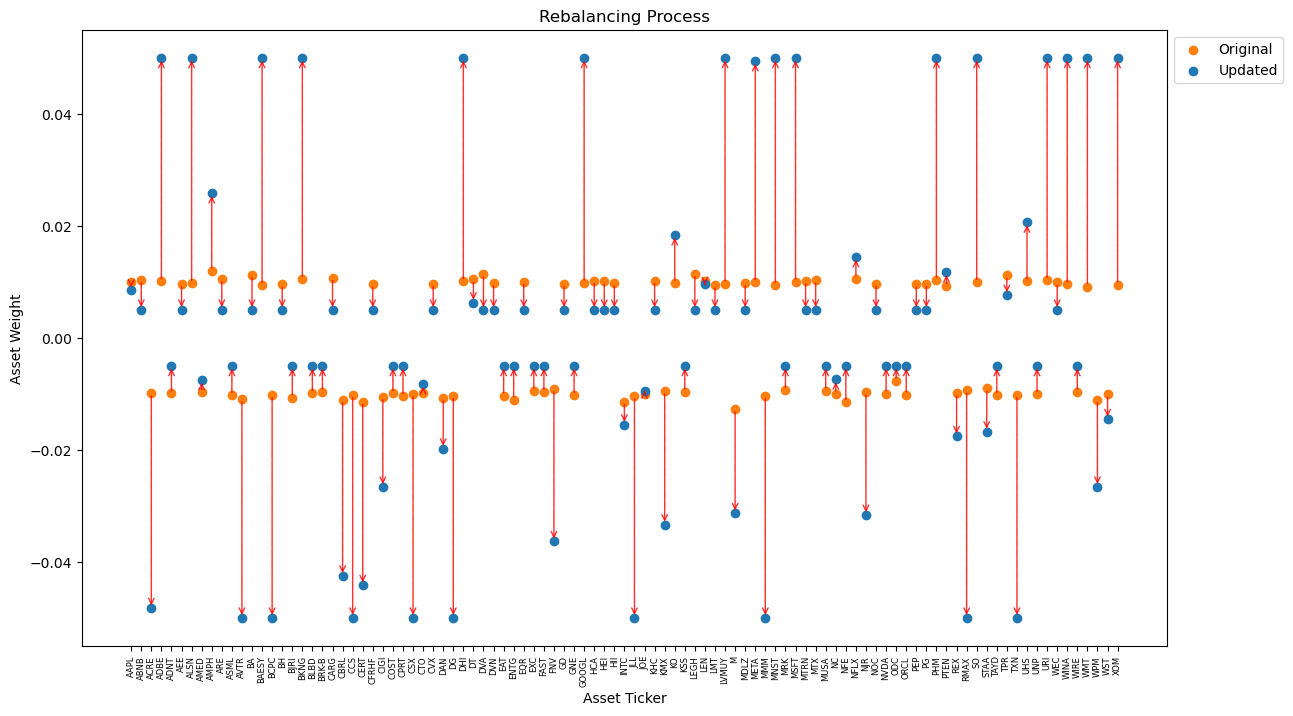

In [24]:
# Set the plot size
plt.figure(figsize=(14, 8))

# Scatter plot
plt.scatter(range(Weight_comparison.shape[0]), Weight_comparison['Original'], label='Original', color='#ff7f0e')
plt.scatter(range(Weight_comparison.shape[0]), Weight_comparison['Updated'], label='Updated', color='#1f77b4')
plt.title('Scatter Plot')
plt.xlabel('Asset Ticker')
plt.ylabel('Asset Weight')

# Move the legend outside the graph
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')


for i in range(Weight_comparison.shape[0]):
    plt.plot([i, i], [Weight_comparison['Original'][i], Weight_comparison['Updated'][i]], '--',color='#ff7f0e', alpha = 0.1)
    plt.annotate("", xy=(i, Weight_comparison['Updated'][i]), xytext=(i, Weight_comparison['Original'][i]),
                 arrowprops=dict(arrowstyle="->", color='red', alpha=0.8))


# Assign labels to x-axis values
plt.xticks(range(Weight_comparison.shape[0]), labels= df_asset['Ticker'], rotation=90, fontsize=6)


plt.title('Rebalancing Process')
plt.show()

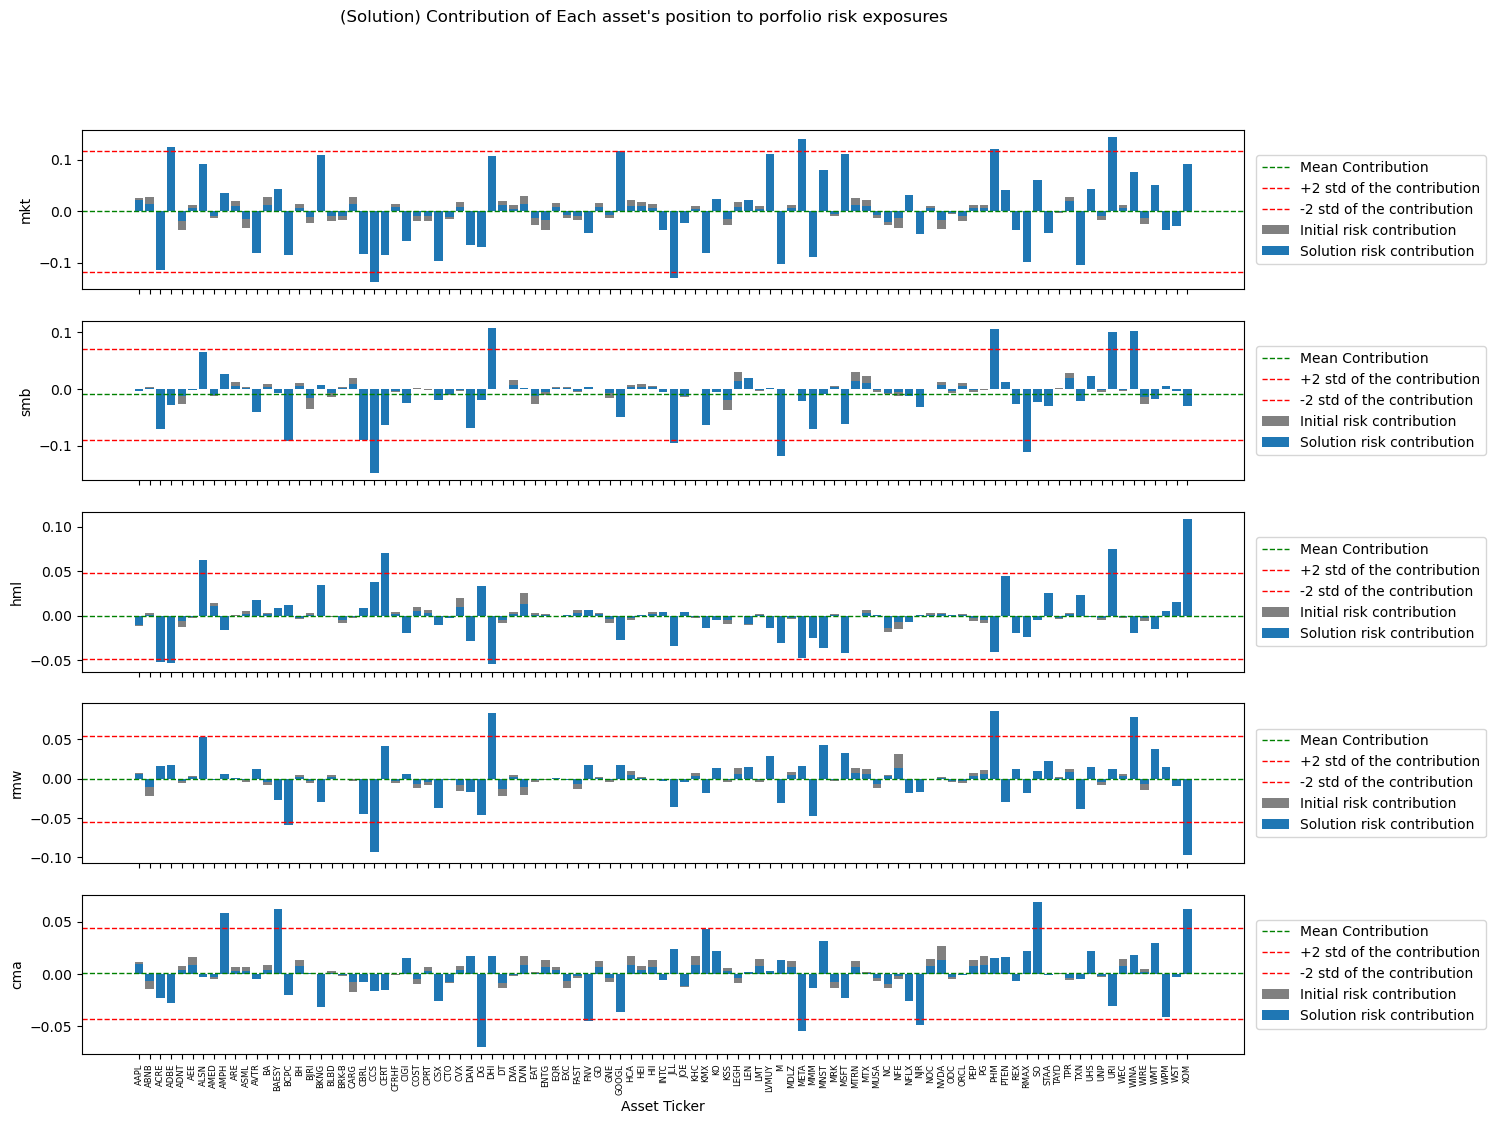

In [25]:
# Set the plot size
fig, axs = plt.subplots(5, 1, figsize=(15, 12), sharex=True)


portolio_risk_upper_bound = [mkt_beta_upper_bound,smb_beta_upper_bound,hml_beta_upper_bound,rmw_beta_upper_bound,cma_beta_upper_bound]
portolio_risk_lower_bound = [mkt_beta_lower_bound,smb_beta_lower_bound,hml_beta_lower_bound,rmw_beta_lower_bound,cma_beta_lower_bound]




# Plot each column in a separate subplot
for i, col in enumerate(['mkt', 'smb', 'hml', 'rmw', 'cma']):
    
    #axs[i].scatter(df_asset.index, df_asset[col] * df_asset['Beta_weight'] * 2, label='Asset contribution')
    axs[i].bar(df_asset.index, df_asset[col] * df_asset['Beta_weight'] * 2, color = 'grey', label='Initial risk contribution')
    axs[i].bar(df_asset.index, df_asset[col] * result.x * 2, color = '#1f77b4', label='Solution risk contribution')
    
    axs[i].set_ylabel(col)
    
    #plot the portfolio weighted-average beta
    axs[i].axhline(y=(df_asset[col]*result.x).mean()*2, color='green', linestyle='--', linewidth=1, label='Mean Contribution')  # Add horizontal line at y=0
     
    #plot the contribution  +-2*std
    axs[i].axhline(y = (df_asset[col]*result.x).mean()*2+(df_asset[col]*result.x).std()*2*2, color='red', linestyle='--', linewidth=1, label='+2 std of the contribution') 
    axs[i].axhline(y = (df_asset[col]*result.x).mean()*2-(df_asset[col]*result.x).std()*2*2, color='red', linestyle='--', linewidth=1, label='-2 std of the contribution') 
    
    axs[i].legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.)

    

# Add labels and title
plt.xlabel('Asset Ticker')
plt.suptitle("(Solution) Contribution of Each asset's position to porfolio risk exposures")

plt.xticks(range(Weight_comparison.shape[0]), labels= df_asset['Ticker'], rotation=90, fontsize=6)


plt.show()

# output GIF

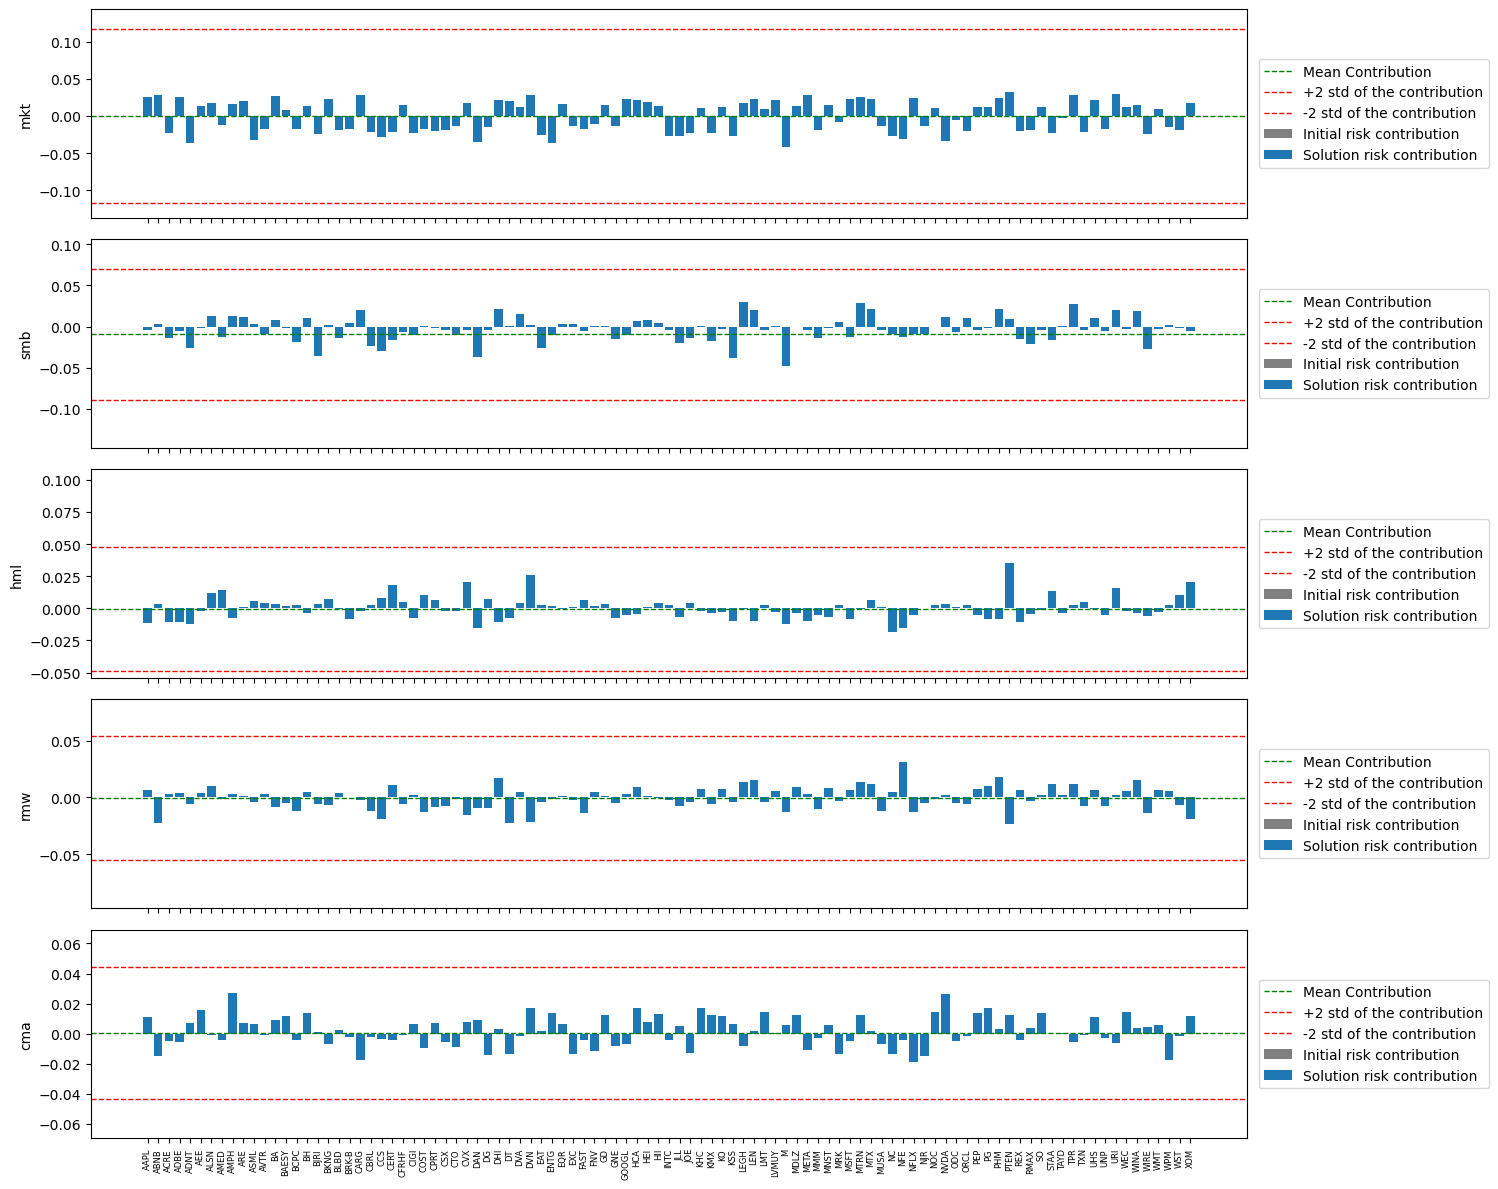

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

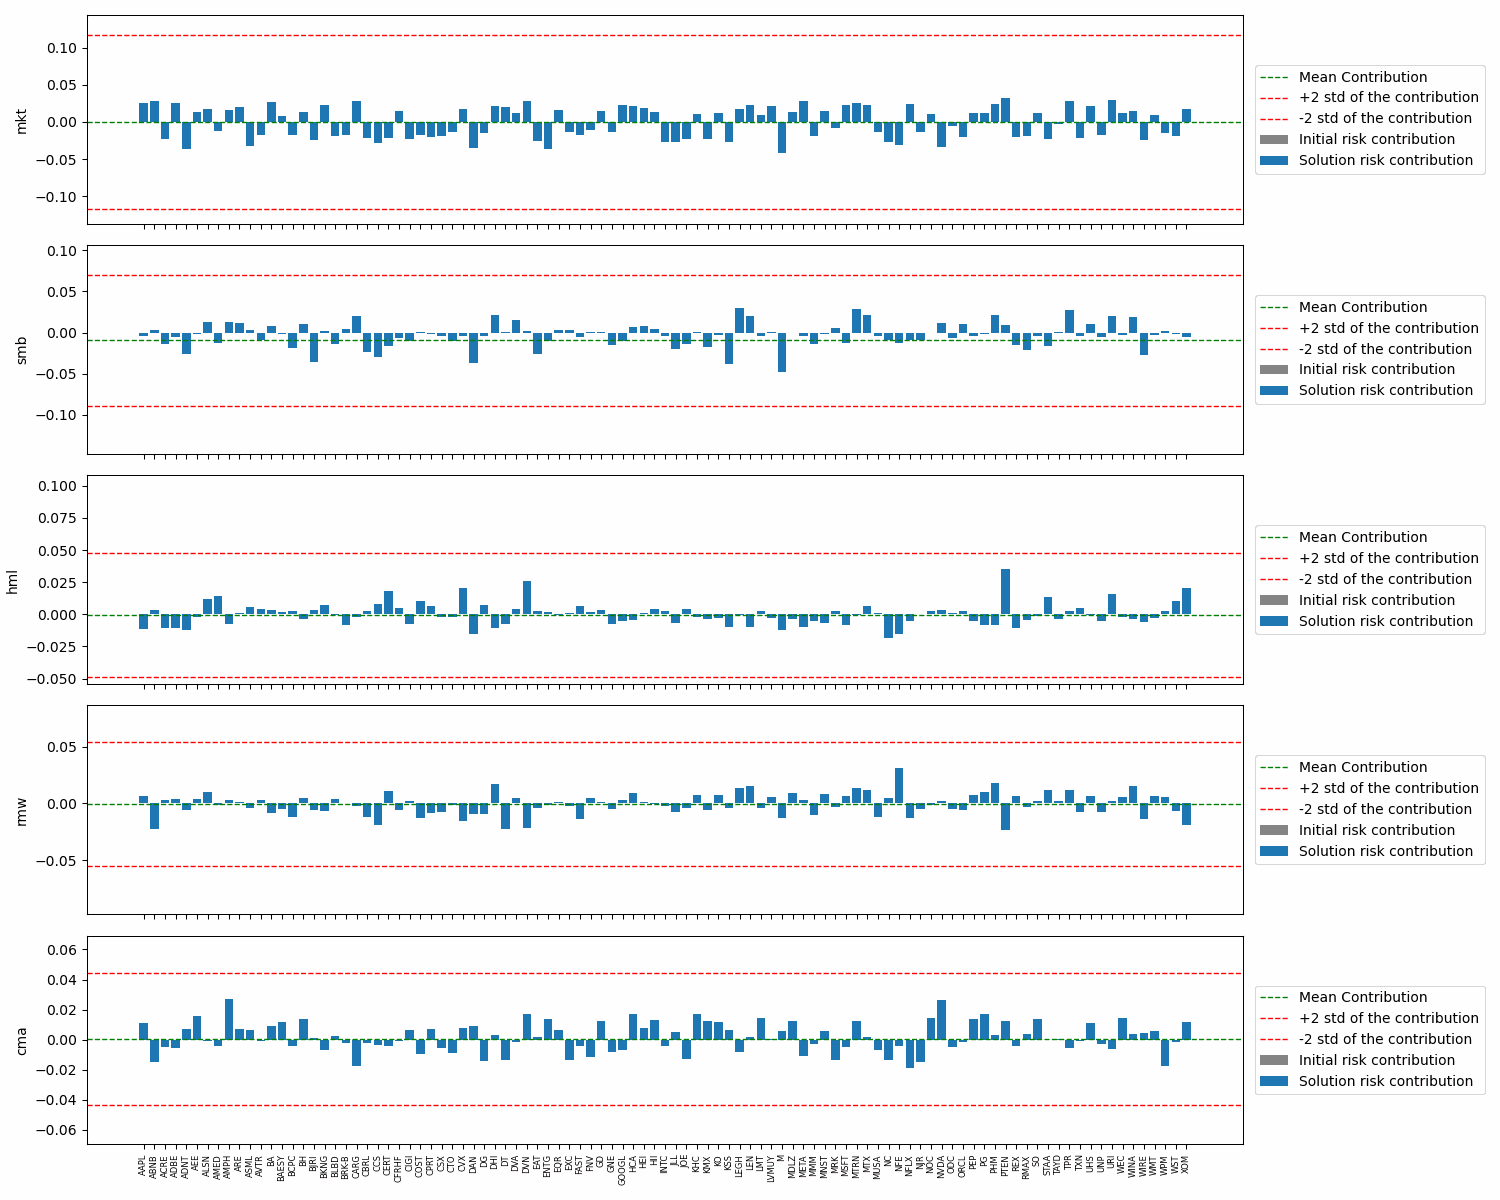

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
from PIL import Image  # Pillow library

# Assuming df_asset and result are defined

def plot_dynamic(axs, df_asset, weights):
    # Plot each column in a separate subplot
    for i, col in enumerate(['mkt', 'smb', 'hml', 'rmw', 'cma']):
        axs[i].clear()  # Clear the previous content

        # Plot bars for initial and solution risk contribution
        axs[i].bar(df_asset.index, df_asset[col] * df_asset['Beta_weight'] * 2, color='grey', label='Initial risk contribution')
        axs[i].bar(df_asset.index, df_asset[col] * weights * 2, color='#1f77b4', label='Solution risk contribution')

        axs[i].set_ylabel(col)

        # Plot the mean contribution 
        axs[i].axhline(y=(df_asset[col] * result.x).mean() * 2, color='green', linestyle='--', linewidth=1,
                       label='Mean Contribution')

        # Plot the contribution +-2*std
        axs[i].axhline(y=(df_asset[col] * result.x).mean() * 2 + (df_asset[col] * result.x).std() * 2 * 2,
                       color='red', linestyle='--', linewidth=1, label='+2 std of the contribution')
        axs[i].axhline(y=(df_asset[col] * result.x).mean() * 2 - (df_asset[col] * result.x).std() * 2 * 2,
                       color='red', linestyle='--', linewidth=1, label='-2 std of the contribution')

        axs[i].legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.)
         # Set y-axis limits based on final weights
        axs[i].set_ylim((df_asset[col] * final_weights).min() * 2, (df_asset[col] * final_weights).max() * 2)
        
        # Add xticks only to the last subplot
        if i == len(axs) - 1:
            axs[i].set_xticks(df_asset.index,df_asset['Ticker'], rotation=90, fontsize=6)
    #plt.xticks(range(Weight_comparison.shape[0]), labels= df_asset['Ticker'], rotation=90, fontsize=6)
    plt.tight_layout()


def update(frame, initial_weights, final_weights):
    # Interpolate between initial and final solutions
    weights = initial_weights + (final_weights - initial_weights) * frame / num_frames

    axs[0].clear()  # Clear the previous content
    plot_dynamic(axs, df_asset, weights)
    plt.pause(0.00005)

# Set the plot size
fig, axs = plt.subplots(5, 1, figsize=(15, 12), sharex=True)

# Initial and final weights
initial_weights = df_asset['Beta_weight'] 
final_weights = result.x 

# Number of frames
num_frames = 10

# Create the animation
animation = FuncAnimation(fig, update, frames=num_frames, fargs=(initial_weights, final_weights), repeat=False)

# Save the animation as a GIF
animation.save('dynamic_plot.gif', writer='pillow', fps=5)

# Display the animation in the notebook
plt.close()
display(Image.open('dynamic_plot.gif'))


In [27]:
(df_asset['mkt']*result.x)

0     0.010774
1     0.006836
2    -0.056915
3     0.062312
4    -0.009185
        ...   
94   -0.006339
95    0.025422
96   -0.018188
97   -0.013931
98    0.046124
Name: mkt, Length: 99, dtype: float64

In [28]:
(df_asset['mkt']*result.x*2).std()

0.05862092546500435

# Efficient frontier

0 / 20
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
0 / 20
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20


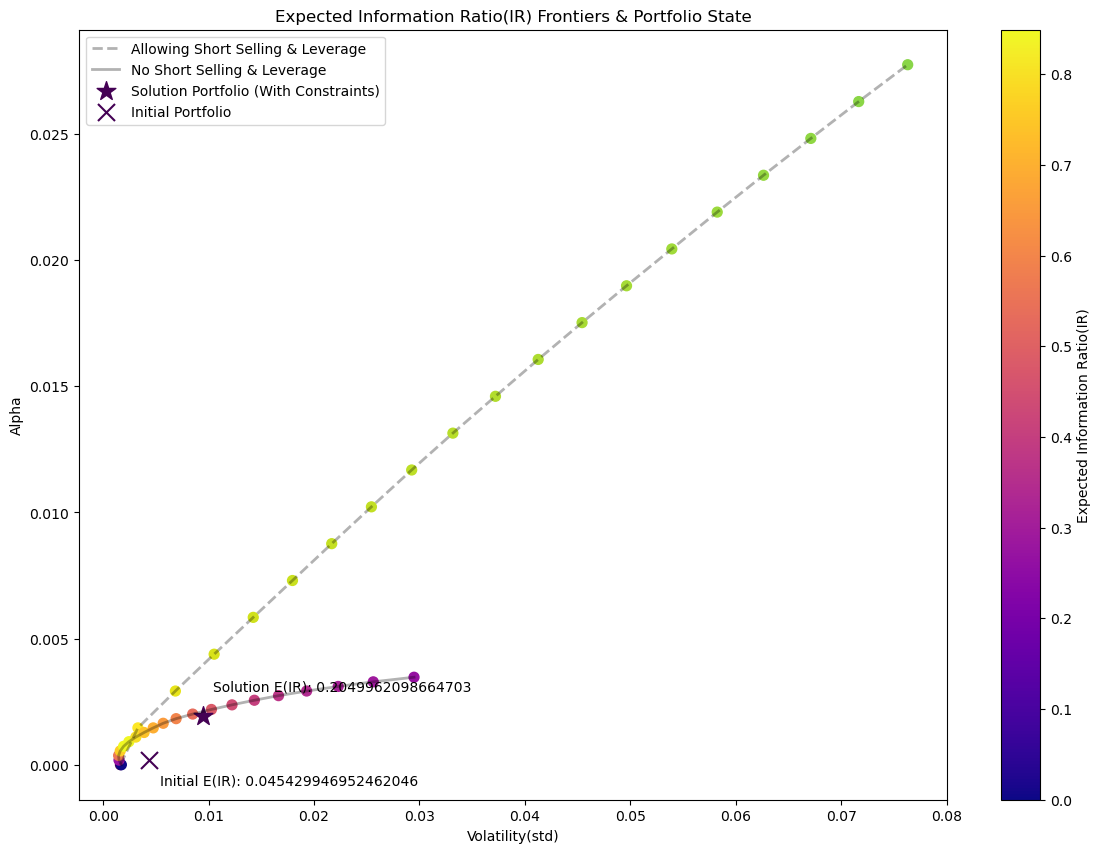

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.cm import ScalarMappable

def calculate_portfolio_return(weights, returns):
    return np.dot(weights, returns)

def calculate_portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def objective_function_2(weights, returns, cov_matrix, risk_free_rate):
    portfolio_return = calculate_portfolio_return(weights, returns)
    portfolio_volatility = calculate_portfolio_volatility(weights, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio  # Minimize the negative of the Sharpe ratio

def optimize_weights(returns, cov_matrix, risk_free_rate, allow_short=True):
    num_assets = len(returns)
    
    if allow_short:
        bounds = tuple((-1, 1) for asset in range(num_assets))
    else:
        bounds = tuple((0, 1) for asset in range(num_assets))

    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    initial_weights = np.ones(num_assets) / num_assets  # Equal weights to start with

    result = minimize(
        objective_function_2,
        initial_weights,
        args=(returns, cov_matrix, risk_free_rate),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    return result.x

def generate_efficient_frontier(returns, cov_matrix, risk_free_rate, allow_short=True, num_points=20):
    efficient_frontier = []
    #target_returns = np.linspace(min(returns), max(returns), num_points)
    target_returns = np.linspace(0, max(returns), num_points)
    

    for i, target_return in enumerate(target_returns):
        print(str(i),"/",str(len(target_returns)))
        

        if allow_short:
            bounds = tuple((-1, 1) for asset in range(len(returns)))
            target_return = target_return * 8 # be cautious !! this is just for plotting purpose!! should be remove in future applicaiton
        else:
            bounds = tuple((0, 1) for asset in range(len(returns)))
            
        constraints = ({'type': 'eq', 'fun': lambda weights: calculate_portfolio_return(weights, returns) - target_return},
                       {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

        result = minimize(
            calculate_portfolio_volatility,
            x0=np.ones(len(returns)) / len(returns),
            args=(cov_matrix,),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )

        efficient_frontier.append([target_return, result.fun, (target_return - risk_free_rate) / result.fun])

    return np.array(efficient_frontier)

sharpe_ratio_max = 0

def plot_efficient_frontiers(returns, cov_matrix, risk_free_rate):
    efficient_frontier_short = generate_efficient_frontier(returns, cov_matrix, risk_free_rate, allow_short=True)
    efficient_frontier_no_short = generate_efficient_frontier(returns, cov_matrix, risk_free_rate, allow_short=False)

    
    # Set up a colormap
    cmap = plt.get_cmap('viridis')
    max_sharpe_both = max(np.max(efficient_frontier_short[:, 2]), np.max(efficient_frontier_no_short[:, 2]))
    global sharpe_ratio_max
    sharpe_ratio_max = max_sharpe_both
    # Normalize the Sharpe ratios to be in the range [0, 1] for colormap mapping
    normalized_sharpe_short = efficient_frontier_short[:, 2] / max_sharpe_both
    normalized_sharpe_no_short = efficient_frontier_no_short[:, 2] / max_sharpe_both

        
    plt.plot(efficient_frontier_short[:, 1], efficient_frontier_short[:, 0], color='black', linestyle = '--', label='Allowing Short Selling & Leverage', alpha=0.3, linewidth=2)
    plt.plot(efficient_frontier_no_short[:, 1], efficient_frontier_no_short[:, 0], color='black', linestyle = '-', label='No Short Selling & Leverage', alpha=0.3, linewidth=2)
    
    # Add colored points based on Sharpe ratio
    plt.scatter(efficient_frontier_short[:, 1], efficient_frontier_short[:, 0], c=normalized_sharpe_short, cmap='viridis', marker='o', s = 50)
    plt.scatter(efficient_frontier_no_short[:, 1], efficient_frontier_no_short[:, 0], c=normalized_sharpe_no_short, cmap='plasma', marker='o', s=50)
   
    
    
    plt.colorbar(label='Expected Information Ratio(IR)')
    
    
    plt.title('Expected Information Ratio(IR) Frontiers & Portfolio State')
    plt.xlabel('Volatility(std)')
    plt.ylabel('Alpha')
    #plt.legend()
    #plt.show()

# Example usage:
returns = alphas  # replace with your asset returns
cov_matrix = cov_residuals  # replace with your covariance matrix
risk_free_rate = 0.00  # replace with your risk-free rate


plt.figure(figsize=(14,10))# Adjust the width and height as needed

plot_efficient_frontiers(returns, cov_matrix, risk_free_rate)

Solution_IR = (portfolio_alpha(result.x, alphas)/np.sqrt(portfolio_variance(result.x, cov_residuals)))
Initial_IR = (portfolio_alpha(initial_weight, alphas)/np.sqrt(portfolio_variance(initial_weight, cov_residuals)))

plt.scatter(np.sqrt(portfolio_variance(result.x, cov_residuals)), portfolio_alpha(result.x, alphas), label = 'Solution Portfolio (With Constraints)',  marker='*', c = Solution_IR /sharpe_ratio_max , s = 200)
plt.scatter(np.sqrt(portfolio_variance(initial_weight, cov_residuals)), portfolio_alpha(initial_weight, alphas), label = 'Initial Portfolio',  marker='x', c = Initial_IR/sharpe_ratio_max, s= 150)


plt.text(np.sqrt(portfolio_variance(result.x, cov_residuals)) + 0.001, portfolio_alpha(result.x, alphas) + 0.001, 'Solution E(IR): ' + str(Solution_IR ), color='black', fontsize=10, ha='left')
plt.text(np.sqrt(portfolio_variance(initial_weight, cov_residuals)) + 0.001, portfolio_alpha(initial_weight, alphas) - 0.001, 'Initial E(IR): ' + str(Initial_IR), color='black', fontsize=10, ha='left')


plt.legend() 
plt.show()

In [30]:
(portfolio_alpha(result.x, alphas)/np.sqrt(portfolio_variance(result.x, cov_residuals)))

0.38475844632451195

In [31]:
sharpe_ratio_max

1.1837747218037933

In [32]:
result.x@alphas

0.0014732620017317338

In [33]:
portfolio_alpha(result.x, alphas)

0.0029465240034634676

In [34]:
np.sqrt(portfolio_variance(result.x, cov_residuals))

0.007658113893563023

In [35]:
portfolio_alpha(result.x, alphas)/np.sqrt(portfolio_variance(result.x, cov_residuals))

0.38475844632451195

In [36]:
initial_weight

array([ 0.0099352 ,  0.01034927, -0.00986236,  0.01010363, -0.0099337 ,
        0.00963489,  0.00980192, -0.00972035,  0.01201944,  0.01049386,
       -0.0102599 , -0.01093406,  0.01123449,  0.00940263, -0.01016313,
        0.00956092, -0.01067561,  0.01053335, -0.00988223, -0.00966822,
        0.01074547, -0.01113493, -0.0101785 , -0.01140752,  0.00955572,
       -0.01057071, -0.00990333, -0.01044238, -0.01003401, -0.00987517,
        0.00969746, -0.01076358, -0.01035955,  0.01010683,  0.0104412 ,
        0.01131499,  0.00980726, -0.01031215, -0.01101643,  0.0100219 ,
       -0.00942383, -0.00970272, -0.00916026,  0.00966312, -0.0102354 ,
        0.0098111 ,  0.01019053,  0.01007294,  0.00978836, -0.01139942,
       -0.01041047, -0.01003467,  0.01023225, -0.00951537,  0.00980966,
       -0.00964288,  0.01140381,  0.01007347,  0.00942457,  0.00962492,
       -0.01269963,  0.00979843,  0.00991358, -0.01037976,  0.00942733,
       -0.00934588,  0.01002926,  0.01013479,  0.01026567, -0.00

In [37]:
beta_calculation_long_short_strategy(np.array(df_asset[col]), np.array(df_asset['Beta_weight']))

0.17225038691976913

In [38]:
mkt_beta_upper_bound

0.05

# industry distribution

In [76]:

## for industry distribution

import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
import time

def get_Sector_from_yahoo(ticker):
    url = f"https://finance.yahoo.com/quote/{ticker}/profile?p={ticker}"

    try:
        
        
        options = webdriver.ChromeOptions()
        options.add_argument('--headless')

        driver = webdriver.Chrome(options=options)

        driver.get(url)

        # Remove the following line because it's not needed with WebDriverWait
        # driver.find_element(By.CLASS_NAME, 'Pt(10px) smartphone_Pt(20px) Lh(1.7)').text

        # Wait for the presence of an element with the specified class name
        element = WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.XPATH, '//*[@id="Col1-0-Profile-Proxy"]/section/div[1]/div/div/p[2]/span[2]'))
        )

        # Now you can interact with the 'element' variable as needed
        # For example, printing the text of the element
        
        sector_name = element.text

    except requests.exceptions.HTTPError as errh:
        print(f"HTTP Error: {errh}")
        time.sleep(2)
        print('Recursion activated!!')
        sector_name = get_Sector_from_yahoo(ticker)
        
    except requests.exceptions.RequestException as err:
        print(f"Request Error: {err}")
        time.sleep(2)
        print('Recursion activated!!')
        sector_name = get_Sector_from_yahoo(ticker)
        
    except Exception as e:
        print(f"Request Error: {e}")
        time.sleep(2)
        print('Recursion activated!!')
        sector_name = get_Sector_from_yahoo(ticker)
        
    return sector_name

# Example usage
sector = get_Sector_from_yahoo("AAPL")
print(sector)

Technology


In [77]:
sectors = []
for i, temp_ticker in enumerate(df_asset['Ticker']):
    print('Fetching data for ',temp_ticker ,', Overall Progess:',str(i),'/', df_asset['Ticker'].shape[0])
    sectors.append(get_Sector_from_yahoo(temp_ticker))
    

Fetching data for  AAPL , Overall Progess: 0 / 99
Fetching data for  ABNB , Overall Progess: 1 / 99
Fetching data for  ACRE , Overall Progess: 2 / 99
Fetching data for  ADBE , Overall Progess: 3 / 99
Fetching data for  ADNT , Overall Progess: 4 / 99
Fetching data for  AEE , Overall Progess: 5 / 99
Fetching data for  ALSN , Overall Progess: 6 / 99
Fetching data for  AMED , Overall Progess: 7 / 99
Fetching data for  AMPH , Overall Progess: 8 / 99
Fetching data for  ARE , Overall Progess: 9 / 99
Fetching data for  ASML , Overall Progess: 10 / 99
Fetching data for  AVTR , Overall Progess: 11 / 99
Fetching data for  BA , Overall Progess: 12 / 99
Fetching data for  BAESY , Overall Progess: 13 / 99
Fetching data for  BCPC , Overall Progess: 14 / 99
Fetching data for  BH , Overall Progess: 15 / 99
Fetching data for  BJRI , Overall Progess: 16 / 99
Fetching data for  BKNG , Overall Progess: 17 / 99
Fetching data for  BLBD , Overall Progess: 18 / 99
Fetching data for  BRK-B , Overall Progess: 19

In [79]:
df_asset['Sector'] = sectors

In [81]:
df_asset.to_csv('Position_betas_and_sector.csv')

In [82]:
df_asset

,Unnamed: 0,Symbol,Description,Quantity,Currency,LastPrice,PricePaid,DayChange,ProfitLoss,MarketValue,...,Intercept,mkt,smb,hml,rmw,cma,Ticker,Market_Position,Beta_weight,Sector
0,0,AAPL,Apple Inc,109,USD,189.37,182.61,-1.03,736.84,20641.33,...,0.000297,1.253297,-0.209483,-0.582800,0.329294,0.571891,AAPL,20641.33,0.009935,Technology
1,1,ABNB,Airbnb Inc - Ordinary Shares - Class A,170,USD,126.48,117.23,-1.08,"1,572.50",21501.60,...,0.000575,1.367280,0.146566,0.144253,-1.075227,-0.705166,ABNB,21501.60,0.010349,Consumer Cyclical
2,2,ACRE,Ares Commercial Real Estate Corp,-2049,USD,10.00,9.73,0.12,-553.23,20490.00,...,-0.000084,1.178982,0.725781,0.532266,-0.160280,0.242518,ACRE,-20490.00,-0.009862,Real Estate
3,3,ADBE,Adobe Inc,34,USD,617.39,583.67,-5.93,"1,146.48",20991.26,...,0.000209,1.246249,-0.274567,-0.523537,0.175504,-0.275099,ADBE,20991.26,0.010104,Technology
4,4,ADNT,Adient plc,-636,USD,32.45,31.36,0.28,-693.24,20638.20,...,0.000415,1.837080,1.296819,0.630865,0.289548,-0.360652,ADNT,-20638.20,-0.009934,Consumer Cyclical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,94,WIRE,Encore Wire Corp.,-109,USD,184.34,182.01,-2.99,-253.97,20093.06,...,0.001175,1.267728,1.400722,0.295243,0.722859,-0.230493,WIRE,-20093.06,-0.009671,Industrials
95,95,WMT,Walmart Inc,122,USD,156.08,164.14,-2.56,-983.32,19041.76,...,0.000302,0.508434,-0.174215,-0.151355,0.370443,0.297936,WMT,19041.76,0.009165,Consumer Defensive
96,96,WPM,Wheaton Precious Metals Corp,-468,USD,49.05,42.56,-0.10,"-3,037.32",22955.40,...,0.000422,0.684067,-0.102555,-0.102538,-0.268786,0.784949,WPM,-22955.40,-0.011049,Basic Materials
97,97,WST,"West Pharmaceutical Services, Inc.",-60,USD,348.92,335.51,-3.50,-804.60,20935.20,...,-0.000257,0.957539,0.113884,-0.517079,0.327915,0.089770,WST,-20935.20,-0.010077,Healthcare


In [ ]:
#df_asset[col] * df_asset['Beta_weight'] * 2

In [ ]:
df_asset['Sector']

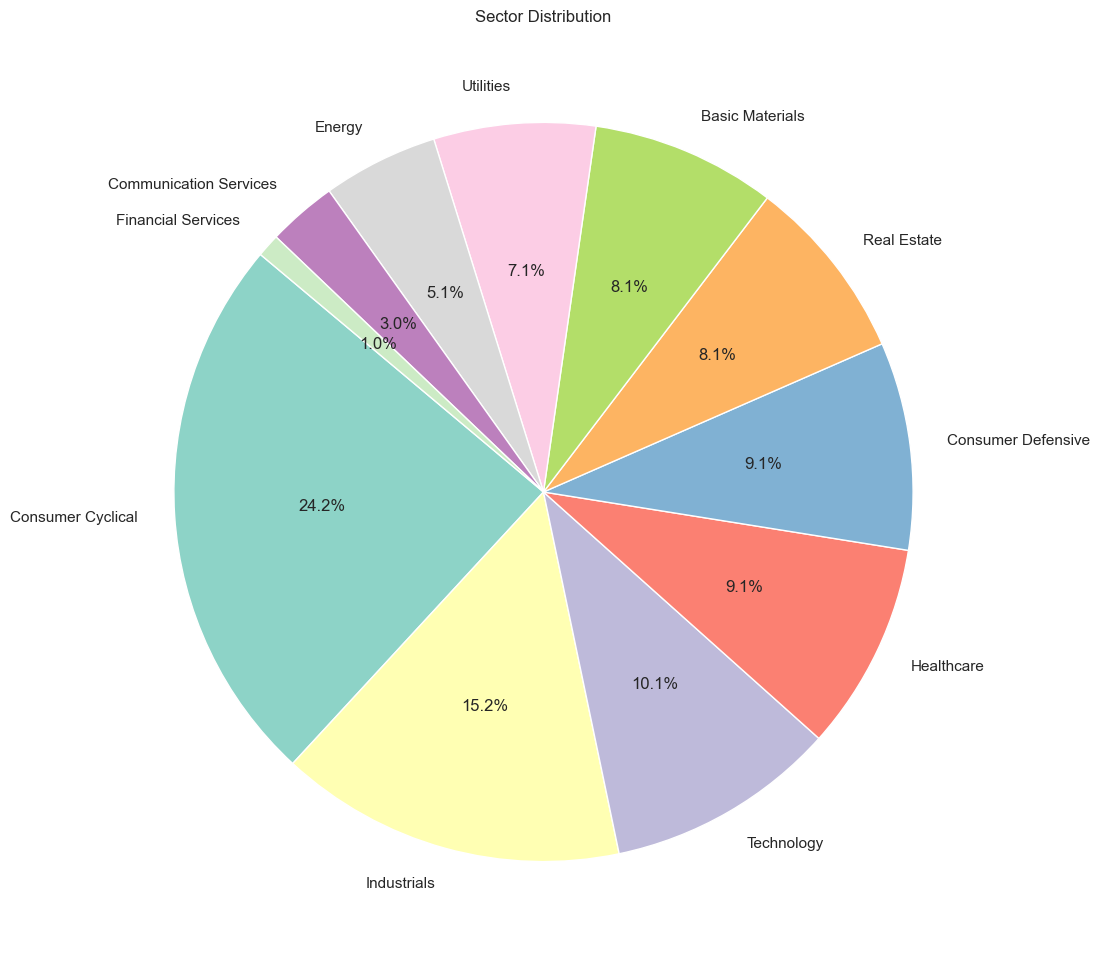

In [156]:
import seaborn as sns


category_counts = df_asset['Sector'].value_counts()

# Create a pie chart using Seaborn and Matplotlib
plt.figure(figsize=(16, 12))
sns.set_palette("Set3")  # Set color palette using Seaborn
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sector Distribution')
plt.show()

In [98]:
df_asset['ProfitLoss'] = df_asset['ProfitLoss'].str.replace(',', '').astype(float)

In [99]:
df_asset.groupby('Sector').sum()

/var/folders/2j/xqk1xvts58v88hvpqrdt8thw0000gn/T/ipykernel_68992/1363676660.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_asset.groupby('Sector').sum()


,Unnamed: 0,Quantity,LastPrice,PricePaid,DayChange,ProfitLoss,MarketValue,ProfitLossPercentage,Position_Weight,Intercept,mkt,smb,hml,rmw,cma,Market_Position,Beta_weight
Sector,,,,,,,,,,,,,,,,,
Basic Materials,456,-2195,576.42,556.9100,-1.86,-3773.59,164607.97,-18.73,0.167082,0.001952,6.656828,4.867573,0.238549,1.139942,2.908684,-79840.17,-0.038429
Communication Services,179,259,944.38,885.4600,-10.81,3289.03,62930.63,16.51,0.063877,0.001378,3.711160,-1.170278,-1.007252,-0.295296,-1.804314,62930.63,0.030290
Consumer Cyclical,934,-3840,5318.46,5168.9075,-11.18,-2840.69,513070.65,-14.39,0.520783,0.008350,27.537156,22.968247,1.169084,7.721420,-2.771727,38633.09,0.018595
Consumer Defensive,541,1775,1409.57,1380.2100,-12.13,-1365.72,182714.47,-6.84,0.185461,-0.000640,5.904717,-0.598738,-2.498650,4.000829,5.436639,98518.35,0.047419
Energy,315,1811,337.85,335.6000,-2.17,-1103.53,100129.90,-5.56,0.101635,0.006558,6.361339,0.507866,6.274430,-4.416665,3.251350,58668.70,0.028239
Financial Services,19,-56,358.69,350.2000,-1.36,-475.44,20086.64,-2.42,0.020389,0.000402,0.894984,-0.197552,0.443184,-0.004556,0.099660,-20086.64,-0.009668
Healthcare,455,-1768,1130.31,1070.7700,0.08,7790.97,193580.43,39.12,0.196490,0.002022,7.671830,4.169083,-3.313110,0.631971,3.662301,-12466.87,-0.006001
Industrials,815,-1870,2982.38,2863.3300,7.53,-65.70,311775.33,-0.17,0.316462,0.007776,12.544952,4.558749,2.181061,2.275497,4.100219,18873.35,0.009084
Real Estate,288,-5550,517.57,481.4500,3.02,-2554.52,167552.95,-12.81,0.170071,-0.003629,8.218639,5.192245,1.352168,0.677942,1.232562,-82306.07,-0.039616


/var/folders/2j/xqk1xvts58v88hvpqrdt8thw0000gn/T/ipykernel_68992/3973959755.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_asset.groupby('Sector').sum()['Market_Position'].plot(kind='bar', color='skyblue', edgecolor='black')


Text(0, 0.5, 'Profit')

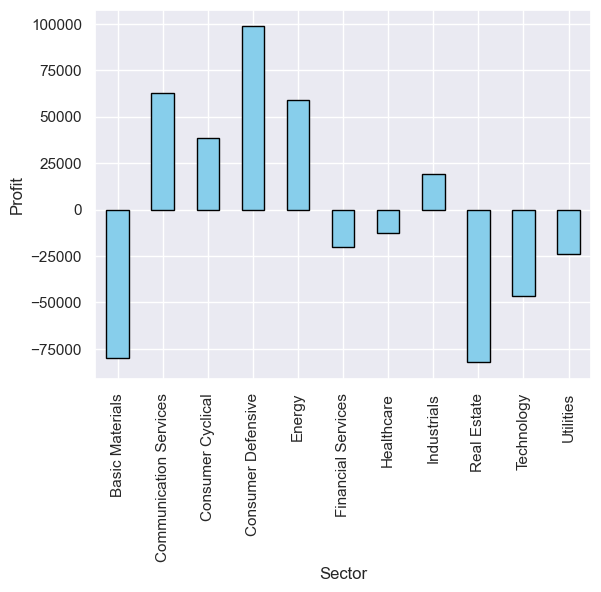

In [104]:
df_asset.groupby('Sector').sum()['ProfitLoss'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.ylabel('Profit')

/var/folders/2j/xqk1xvts58v88hvpqrdt8thw0000gn/T/ipykernel_68992/4222872634.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_asset.groupby('Sector').sum()['Market_Position'].plot(kind='bar', edgecolor='black')


Text(0, 0.5, 'Profit')

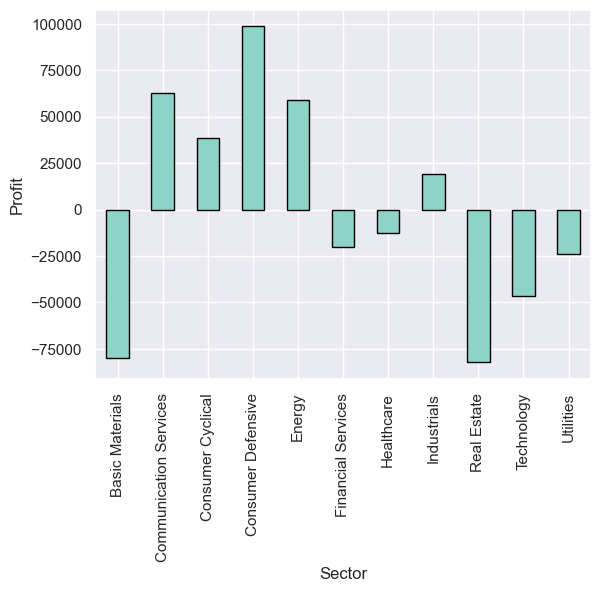

In [106]:
df_asset.groupby('Sector').sum()['Market_Position'].plot(kind='bar', edgecolor='black')
plt.ylabel('Net Position')

/var/folders/2j/xqk1xvts58v88hvpqrdt8thw0000gn/T/ipykernel_68992/2375725161.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax = df_asset.groupby('Sector').sum()[['Beta_weight','Solution Weight']].plot(kind='bar', edgecolor='black')


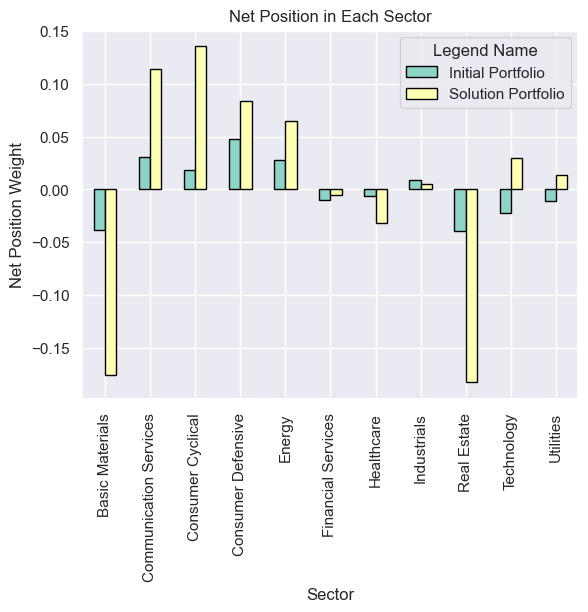

In [154]:
df_asset['Solution Weight'] = result.x
ax = df_asset.groupby('Sector').sum()[['Beta_weight','Solution Weight']].plot(kind='bar', edgecolor='black')

# Change the legend names
legend_names = ['Initial Portfolio', 'Solution Portfolio']
ax.legend(legend_names, title='Legend Name')

plt.ylabel('Net Position Weight')

plt.title('Net Position in Each Sector')

# Show the plot
plt.show()

In [137]:
df_graph = df_asset.copy()
for i in ['mkt', 'smb', 'hml', 'rmw', 'cma']:
    df_graph[i+'_contribution_initial'] = df_graph[i]*df_graph['Beta_weight']*2
    df_graph[i+'_contribution_solution'] = df_graph[i]*df_graph['Solution Weight']*2

In [138]:
df_graph_1 = df_graph.groupby('Sector').sum()

/var/folders/2j/xqk1xvts58v88hvpqrdt8thw0000gn/T/ipykernel_68992/3521658874.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_graph_1 = df_graph.groupby('Sector').sum()


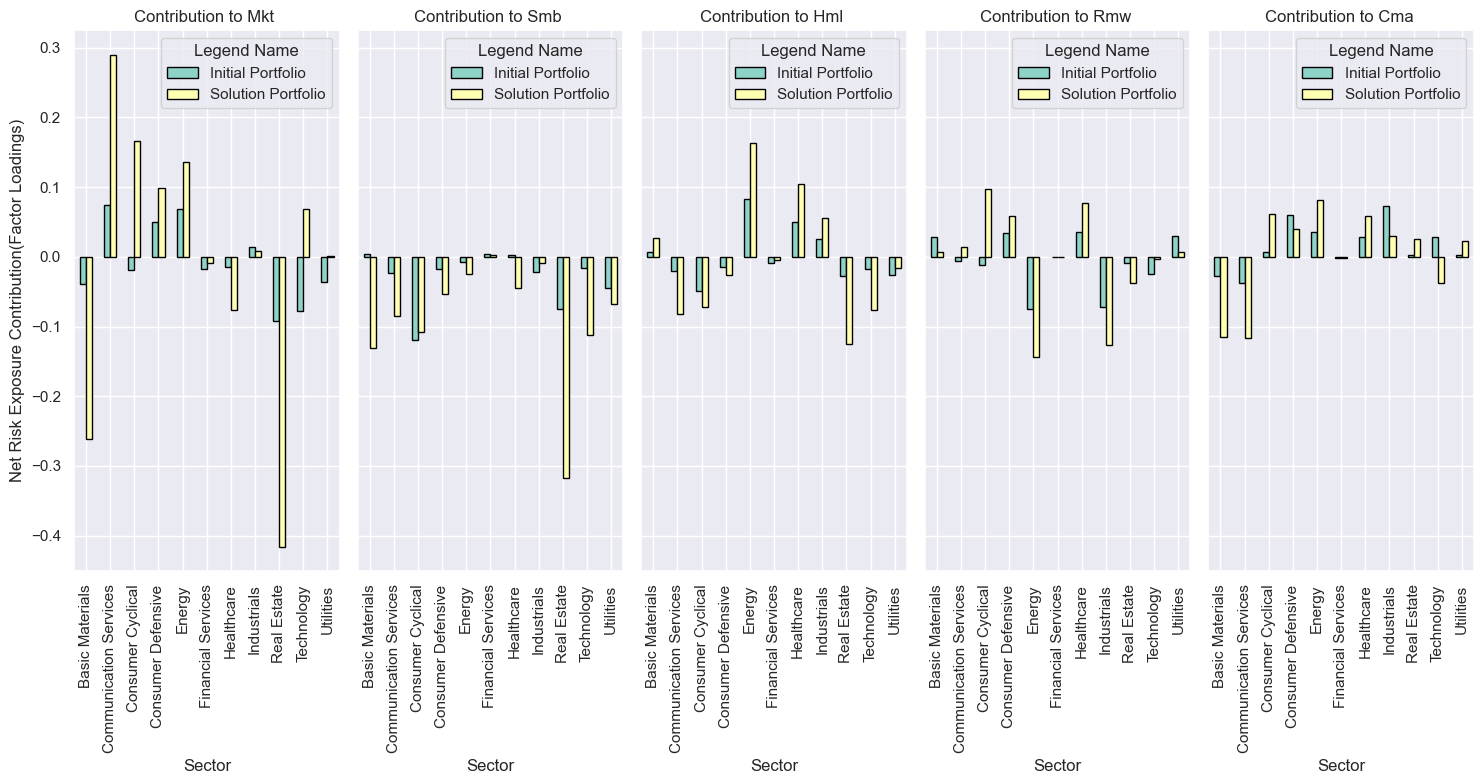

In [153]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 8), sharey=True)

# Iterate through variables and create bar plots in subplots
for i, variable in enumerate(['mkt', 'smb', 'hml', 'rmw', 'cma']):
    df_graph_1[[f'{variable}_contribution_initial', f'{variable}_contribution_solution']].plot(kind='bar', edgecolor='black', ax=axes[i])
    
    # Change the legend names
    legend_names = ['Initial Portfolio', 'Solution Portfolio']
    axes[i].legend(legend_names, title='Legend Name')
    
    # Set y-axis label
    axes[i].set_ylabel('Net Risk Exposure Contribution(Factor Loadings)')
    
    # Set individual subplot titles
    axes[i].set_title(f'Contribution to {variable.capitalize()} ')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [119]:
df_graph['Beta_weight']

,Unnamed: 0,Symbol,Description,Quantity,Currency,LastPrice,PricePaid,DayChange,ProfitLoss,MarketValue,...,mkt,smb,hml,rmw,cma,Ticker,Market_Position,Beta_weight,Sector,Solution Weight
0,0,AAPL,Apple Inc,109,USD,189.37,182.61,-1.03,736.84,20641.33,...,1.253297,-0.209483,-0.582800,0.329294,0.571891,AAPL,20641.33,0.009935,Technology,0.008596
1,1,ABNB,Airbnb Inc - Ordinary Shares - Class A,170,USD,126.48,117.23,-1.08,1572.50,21501.60,...,1.367280,0.146566,0.144253,-1.075227,-0.705166,ABNB,21501.60,0.010349,Consumer Cyclical,0.005000
2,2,ACRE,Ares Commercial Real Estate Corp,-2049,USD,10.00,9.73,0.12,-553.23,20490.00,...,1.178982,0.725781,0.532266,-0.160280,0.242518,ACRE,-20490.00,-0.009862,Real Estate,-0.048275
3,3,ADBE,Adobe Inc,34,USD,617.39,583.67,-5.93,1146.48,20991.26,...,1.246249,-0.274567,-0.523537,0.175504,-0.275099,ADBE,20991.26,0.010104,Technology,0.050000
4,4,ADNT,Adient plc,-636,USD,32.45,31.36,0.28,-693.24,20638.20,...,1.837080,1.296819,0.630865,0.289548,-0.360652,ADNT,-20638.20,-0.009934,Consumer Cyclical,-0.005000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,94,WIRE,Encore Wire Corp.,-109,USD,184.34,182.01,-2.99,-253.97,20093.06,...,1.267728,1.400722,0.295243,0.722859,-0.230493,WIRE,-20093.06,-0.009671,Industrials,-0.005000
95,95,WMT,Walmart Inc,122,USD,156.08,164.14,-2.56,-983.32,19041.76,...,0.508434,-0.174215,-0.151355,0.370443,0.297936,WMT,19041.76,0.009165,Consumer Defensive,0.050000
96,96,WPM,Wheaton Precious Metals Corp,-468,USD,49.05,42.56,-0.10,-3037.32,22955.40,...,0.684067,-0.102555,-0.102538,-0.268786,0.784949,WPM,-22955.40,-0.011049,Basic Materials,-0.026588
97,97,WST,"West Pharmaceutical Services, Inc.",-60,USD,348.92,335.51,-3.50,-804.60,20935.20,...,0.957539,0.113884,-0.517079,0.327915,0.089770,WST,-20935.20,-0.010077,Healthcare,-0.014548


/var/folders/2j/xqk1xvts58v88hvpqrdt8thw0000gn/T/ipykernel_68992/1131780659.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_asset.groupby('Sector').sum()['Solution Weight'].plot(kind='bar', color='skyblue', edgecolor='black')


Text(0, 0.5, 'Solution Net Position')

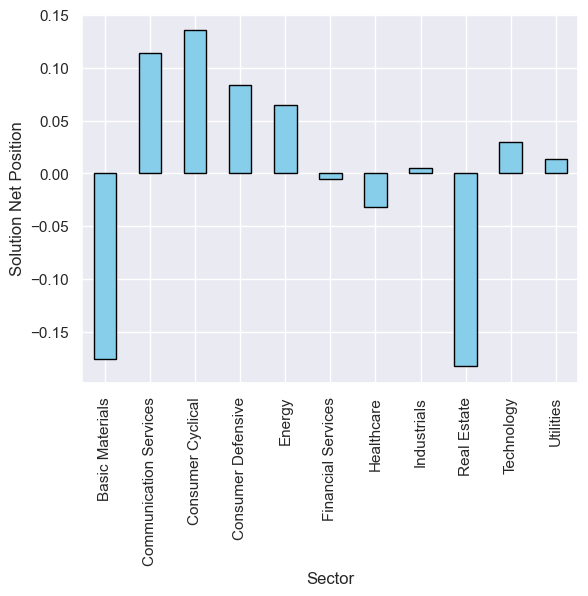

In [111]:
df_asset['Solution Weight'] = result.x
df_asset.groupby('Sector').sum()['Solution Weight'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.ylabel('Solution Net Position')

# Tool box efficient frontier

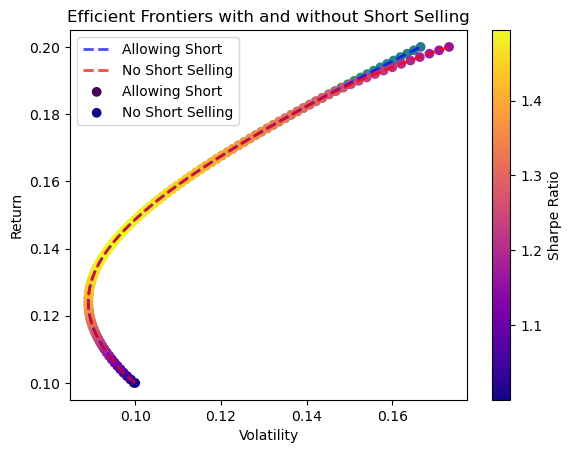

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def calculate_portfolio_return(weights, returns):
    return np.dot(weights, returns)

def calculate_portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def objective_function(weights, returns, cov_matrix, risk_free_rate):
    portfolio_return = calculate_portfolio_return(weights, returns)
    portfolio_volatility = calculate_portfolio_volatility(weights, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio  # Minimize the negative of the Sharpe ratio

def optimize_weights(returns, cov_matrix, risk_free_rate, allow_short=True):
    num_assets = len(returns)
    
    if allow_short:
        bounds = tuple((-1, 1) for asset in range(num_assets))
    else:
        bounds = tuple((0, 1) for asset in range(num_assets))

    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    initial_weights = np.ones(num_assets) / num_assets  # Equal weights to start with

    result = minimize(
        objective_function,
        initial_weights,
        args=(returns, cov_matrix, risk_free_rate),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    return result.x

def generate_efficient_frontier(returns, cov_matrix, risk_free_rate, allow_short=True, num_points=100):
    efficient_frontier = []
    target_returns = np.linspace(min(returns), max(returns), num_points)

    for target_return in target_returns:
        constraints = ({'type': 'eq', 'fun': lambda weights: calculate_portfolio_return(weights, returns) - target_return},
                       {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

        if allow_short:
            bounds = tuple((-1, 1) for asset in range(len(returns)))
        else:
            bounds = tuple((0, 1) for asset in range(len(returns)))

        result = minimize(
            calculate_portfolio_volatility,
            x0=np.ones(len(returns)) / len(returns),
            args=(cov_matrix,),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )

        efficient_frontier.append([target_return, result.fun, (target_return - risk_free_rate) / result.fun])

    return np.array(efficient_frontier)

def plot_efficient_frontiers(returns, cov_matrix, risk_free_rate):
    efficient_frontier_short = generate_efficient_frontier(returns, cov_matrix, risk_free_rate, allow_short=True)
    efficient_frontier_no_short = generate_efficient_frontier(returns, cov_matrix, risk_free_rate, allow_short=False)

    plt.plot(efficient_frontier_short[:, 1], efficient_frontier_short[:, 0], 'b--', label='Allowing Short', alpha=0.7, linewidth=2)
    plt.plot(efficient_frontier_no_short[:, 1], efficient_frontier_no_short[:, 0], 'r--', label='No Short Selling', alpha=0.7, linewidth=2)
    
    # Add colored points based on Sharpe ratio
    plt.scatter(efficient_frontier_short[:, 1], efficient_frontier_short[:, 0], c=efficient_frontier_short[:, 2], cmap='viridis', marker='o', label='Allowing Short')
    plt.scatter(efficient_frontier_no_short[:, 1], efficient_frontier_no_short[:, 0], c=efficient_frontier_no_short[:, 2], cmap='plasma', marker='o', label='No Short Selling')
    plt.colorbar(label='Sharpe Ratio')
    
    
    plt.title('Efficient Frontiers with and without Short Selling')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

# Example usage:
returns = np.array([0.1, 0.15, 0.2])  # replace with your asset returns
cov_matrix = np.array([[0.01, 0.005, 0.002],
                       [0.005, 0.02, 0.01],
                       [0.002, 0.01, 0.03]])  # replace with your covariance matrix
risk_free_rate = 0.00  # replace with your risk-free rate

plot_efficient_frontiers(returns, cov_matrix, risk_free_rate)
